## Задача 12

Предсказать сорт винограда из которого сделано вино, используя результаты химических анализов (описание данных), c помощью KNN - метода k ближайших соседей с тремя различными метриками. Построить график зависимости величины ошибки от числа соседей k. 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.neighbors
import sklearn.metrics
import sklearn.preprocessing
import sklearn.pipeline

import warnings
warnings.filterwarnings("always")


In [9]:
# Удобная обертка над tqdm для возможности итерации по декартовому произведению некоторых множеств
import tqdm
import itertools
import operator
import functools

def tqdm_cross(*args):
    total_length = functools.reduce(operator.mul, map(len, args), 1)
    return tqdm.tqdm(itertools.product(*args), total=total_length)    
    

Считаем данные, подпишем столбцы согласно описанию набора данных (http://archive.ics.uci.edu/ml/datasets/Wine)

In [10]:
dataframe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
dataframe.columns = ['Y', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD/OD of diluted wines', 'Proline ']
dataframe.head()

,Y,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD/OD of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Разделим данные, определять точность моделей будем с помощью кросс валидации. От выборки отделяется в виде тестовой одна точка. Также учтем, что для использования методов ближайших соседей данные необходимо нормировать.

In [11]:
X, Y = dataframe.drop('Y', axis=1), dataframe['Y']

n_neighbors_list = list(range(1, 20))
metrics_list = ['euclidean', 'manhattan', 'chebyshev']

result_format = {'n_neighbors' : np.int32, 'metric' : 'str', 'mean_error_cv' : np.float32, 'std_err_cv' : np.float32}
results = pd.DataFrame(columns=['n_neighbors', 'metric', 'mean_error_cv', 'std_err_cv']).astype(result_format)

In [12]:
result = []

kfold = sklearn.model_selection.KFold(n_splits=len(dataframe), shuffle=True)

for n_neighbors, metric in tqdm_cross(n_neighbors_list, metrics_list):
        cv_pipeline = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(),
                                                     sklearn.neighbors.KNeighborsClassifier(
                                                         n_neighbors=n_neighbors,
                                                         metric=metric
                                                     ))
        current_result = sklearn.model_selection.cross_val_score(cv_pipeline, X, Y, scoring='accuracy')
        result.append([n_neighbors, metric, np.mean(current_result), np.std(current_result)])

result = pd.DataFrame(result, columns=['n_neighbors', 'metric', 'mean_accuracy_cv', 'std_err_cv'])
result.head()

100%|██████████| 57/57 [00:00<00:00, 106.68it/s]


,n_neighbors,metric,mean_accuracy_cv,std_err_cv
0,1,euclidean,0.932950,0.026749
1,1,manhattan,0.949617,0.023304
2,1,chebyshev,0.910345,0.030899
3,2,euclidean,0.915900,0.035664
4,2,manhattan,0.960920,0.043648


Проведем визуализацию полученных результатов

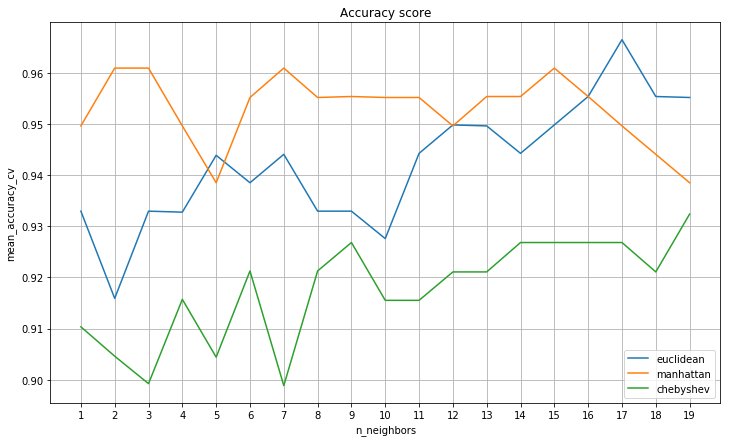

In [14]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

ax.grid()
ax.set_xticks(np.arange(0, 20))
ax.set_yticks(np.arange(0.89, 1, 0.01))
for m in metrics_list:
    ds = result[result['metric'] == m]
    ax.plot(ds.n_neighbors, ds.mean_accuracy_cv, label=m)
    
ax.set_xlabel('n_neighbors')
ax.set_ylabel('mean_accuracy_cv')
ax.set_title('Accuracy score')
ax.legend()


100%|██████████| 3/3 [00:00<00:00, 2685.79it/s]

(1,)
(2,)
(3,)
